# 1. Importation de données

Comprendre les types de données et leur signification physique

In [1]:
import numpy as np 
import pandas as pd 

data_orig = pd.read_csv("xxx.csv")
data_orig.head()

,id,date,number,number_complement,type_voie,street,yanport_quarter,yanport_quarter_code,zip_code,insee_code,city,rooms,area,price_area,price,outdoor_area,longitude,latitude,department
0,5560794,2016-05-12,9006.0,NaN,NaN,PORTE DE LYON,Est,3.704035e+15,69570,69072,DARDILLY,1,30.69,1466.275660,45000.0,0,4.762298,45.821102,69
1,5558094,2016-04-28,NaN,NaN,NaN,MONTCOURAND,Ouest,3.704035e+15,69570,69072,DARDILLY,5,124.50,2538.152610,316000.0,0,4.739229,45.808560,69
2,5347872,2020-03-27,16.0,NaN,NaN,PLACE DE L'EGLISE,Ouest,3.704035e+15,69570,69072,DARDILLY,1,22.00,6276.136364,138075.0,0,4.753133,45.805573,69
3,5447396,2018-10-30,9001.0,NaN,ALL,ALLEE DES TERRASSES,Centre,3.704035e+15,69570,69072,DARDILLY,3,64.00,4002.343750,256150.0,0,4.756403,45.817843,69
4,5557056,2016-12-16,5.0,NaN,CHE,CHEMIN DE PARSONGE,Centre,3.704035e+15,69570,69072,DARDILLY,4,87.99,2727.582680,240000.0,0,4.757383,45.819942,69


Sur la base des explications fournies dans la documentation, on peut classer ces variables comme suit:
- Historique des transactions: 'id','date'
- localisation géographique:
    - 'number', 'number_complement','type_voie','street'
    - 'yanport_quarter','yanport_quarter_code', 'insee_code', 'city'
    - 'zip_code'
    - 'department'
    - 'longitude', 'latitude'
- Informations sur le logement：'rooms', 'area', 'outdoor_area'
- Le but: 'price' / 'price_area'

In [2]:
data_orig.dtypes

id                        int64
date                     object
number                  float64
number_complement        object
type_voie                object
street                   object
yanport_quarter          object
yanport_quarter_code    float64
zip_code                  int64
insee_code                int64
city                     object
rooms                     int64
area                    float64
price_area              float64
price                   float64
outdoor_area              int64
longitude               float64
latitude                float64
department                int64
dtype: object

In [3]:
# Voir la taille des données
data_orig.shape 

(32589, 19)

In [4]:
# Vérification des valeurs nulles
data_orig.isnull().sum()

id                          0
date                        0
number                    228
number_complement       30438
type_voie                 808
street                      0
yanport_quarter          2537
yanport_quarter_code     2537
zip_code                    0
insee_code                  0
city                        0
rooms                       0
area                        0
price_area                 12
price                      12
outdoor_area                0
longitude                  10
latitude                   10
department                  0
dtype: int64

In [5]:
# Vérifier s'il n'y a qu'une seule valeur dans "department"
data_orig['department'].value_counts()

69    32589
Name: department, dtype: int64

In [6]:
cols1_to_drop = ['id','department','number_complement']
data = data_orig.drop(cols1_to_drop,axis=1)

# 2. Sélection des caractéristiques

## 2.1 Sélection des caractéristiques géographiques

D'après la description des caractéristiques, on peut constater qu'il existe une forte corrélation entre les caractéristiques concernant la situation géographique.

Pour déterminer la position géographique d'un bâtiment, on peut:
- ( 1 ) utiliser uniquement la latitude et la longitude 
- ( 2 ) utiliser les autres caractéristiques ensemble. Les gammes géographiques décrites par ces caractéristiques sont, dans l'ordre, du plus petit au plus grand,
    - 'number','street'
    - 'yanport_quarter'/ 'yanport_quarter_code','insee_code', 'city'
    - 'zip_code'
- ( 3 ) S'il y a peu de corrélation entre les données, vous pouvez combiner les deux ci-dessus.

On examine d'abord la corrélation entre celles de ces caractéristiques numériques et le prix unitaire de la maison

<AxesSubplot:>

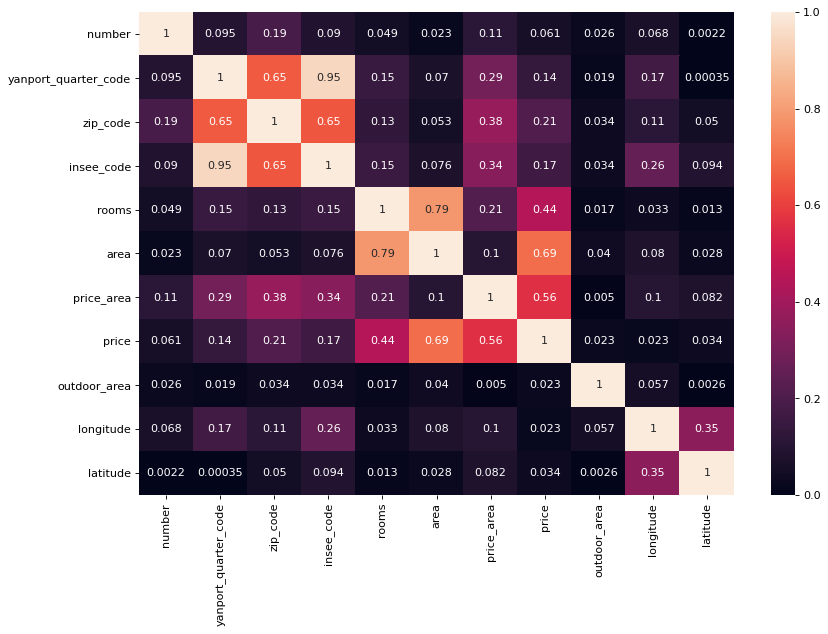

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(12,8),dpi=80)
sns.heatmap(abs(data.corr()),annot =True,vmin = 0, vmax = 1)

On constate que les facteurs qui ont le plus d'impact sur le prix sont les "rooms" et la "area".

Bien que "zip_code","insee_code" et "yanport_quarter_code" soient également corrélés avec le prix, étant donné que les codes artificiels n'ont pas de signification physique spécifique, il ne s'ensuit pas qu'ils soient importants.

Logiquement, l'emplacement peut avoir un impact sur les prix des logements, et cet impact a tendance à être régional.

In [8]:
# Vérifiez s'il y a des valeurs aberrantes dans 'price_area'
data.sort_values(by='price_area',ascending=False)[['price_area','price']][:10]

,price_area,price
21798,25657.894737,1950000.0
8056,18955.349621,225000.0
13671,17850.000000,357000.0
18591,17428.571429,244000.0
2949,15810.276680,240000.0
128,15148.733015,825000.0
5758,15000.000000,210000.0
23806,15000.000000,675000.0
6541,14358.108108,170000.0
16804,14331.946371,930000.0


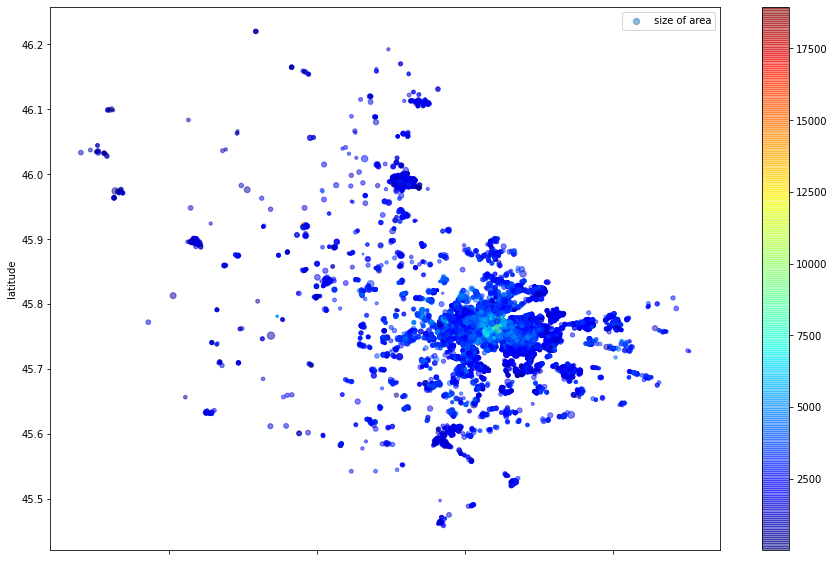

In [9]:
# Suppression la valeur aberrante
data = data[data['price_area']<20000]
data.plot(kind="scatter",x="longitude",y="latitude",alpha=0.5,
            s=data.area/5,label="size of area",
            c=data.price_area,cmap=plt.get_cmap('jet'),colorbar=True,
            figsize=(15, 10))
plt.legend()

On peut clairement observer que les prix unitaires sont plus élevés dans une zone géographique que dans les autres zones.

Il est possible de créer une nouvelle variable pour déterminer si la maison appartient à cette zone.

In [10]:
# Return a list of high price cities' name
def highPriceCities(data:pd.core.frame.DataFrame,higherthan=0.8,houseNumThreshPct=0.01,rankingThreshPct=0.5):
    '''
    @higherthan: fraction that indicates a percentage(max 2 digit, eg: 0.xx), to determine the highPriceThreshold. 
                'price_area' is higher than that percent of total data are defined as "highPrice"
    @houseNumThreshPct: fraction that indicates a percentage, to determine number threshhold for highPriceCity.
                A city where num(highPrice house) more that that thresh can be defined as highPriceCity
    @rankingThreshPct: fraction that indicates a percentage,  to determine ranking threshhold for highPriceCity.
                A city where ranking(num(highPrice house)) top xx% can be defined as highPriceCity
    '''
    data_desc = data['price_area'].describe(percentiles=[higherthan])
    higherthan_str = str(int(higherthan*100))+"%"
    highPriceThresh = data_desc[higherthan_str]
    highPriceData = data[data['price_area'] > highPriceThresh]
    highPriceDataCounts = highPriceData['city'].value_counts()
    totalHouseNum = len(highPriceData)
    houseNumThresh = totalHouseNum*houseNumThreshPct

    totalCityNum = len(highPriceDataCounts)
    rankingThresh = int(totalCityNum*rankingThreshPct)

    cityNames = highPriceDataCounts.index[:rankingThresh]
    cityCadicates = highPriceDataCounts.iloc[:rankingThresh]
   
    highPriceCities = cityNames[cityCadicates > houseNumThresh]
    return list(highPriceCities)

In [11]:
high_price_cities = highPriceCities(data,houseNumThreshPct=0.05)
data['in_high_price_city'] = data.apply(lambda x: 1 if x.city in high_price_cities else 0, axis=1)
data['in_high_price_city'].value_counts()

0    21721
1    10855
Name: in_high_price_city, dtype: int64

<AxesSubplot:>

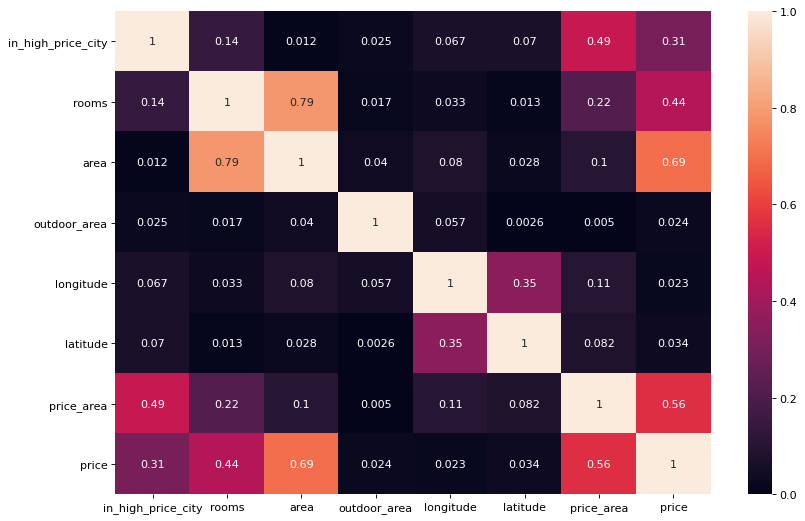

In [12]:
features_cols = ['in_high_price_city','rooms','area','outdoor_area','longitude','latitude','price_area','price']
fig=plt.figure(figsize=(12,8),dpi=80)
sns.heatmap(abs(data[features_cols].corr()),annot =True,vmin = 0, vmax = 1)

On peut constater que cette nouvelle variable 'in_high_price_city' est significativement plus corrélée avec les prix des logements.

Comme le nombre de caractéristiques est intrinsèquement faible et qu'elles ne sont pas très bien corrélées, on garde toutes les caractéristiques ci-dessus.

In [13]:
selected_features = ['in_high_price_city','rooms','area','outdoor_area','longitude','latitude','price']


## 2.2 l'effet du temps sur le prix


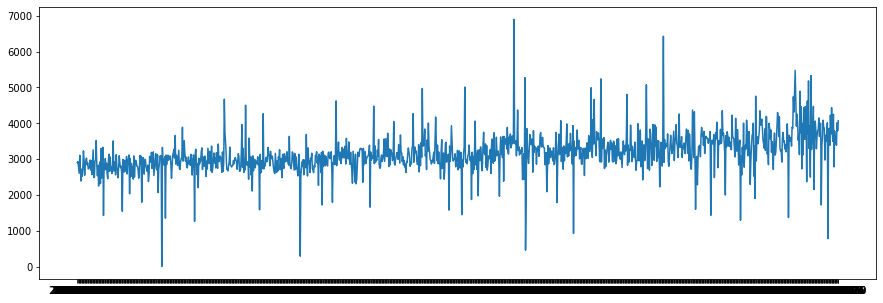

In [14]:
data_time = data.groupby('date').mean()

plt.figure(figsize=(15,5))
plt.plot(data_time.index, data_time['price_area'])
plt.show()

Sur la base du graphique ci-dessus, on peut supposer que le prix unitaire d'une maison n'est pas très étroitement lié au temps dans le cadre temporel fourni.
Ici, pour simplifier le modèle, on laisse de côté l'effet du temps pour le moment.


# 3. Prétraitement des données

## 3.1 valeur manquante

In [49]:
house_data = data[selected_features]
house_data.isnull().sum()

in_high_price_city     0
rooms                  0
area                   0
outdoor_area           0
longitude             10
latitude              10
price                  0
dtype: int64

In [50]:
house_data = house_data.dropna()

## 3.2 distribution des données
Vérifier la présence de valeurs aberrantes (bruit)

array([[<AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'in_high_price_city'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'outdoor_area'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'rooms'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

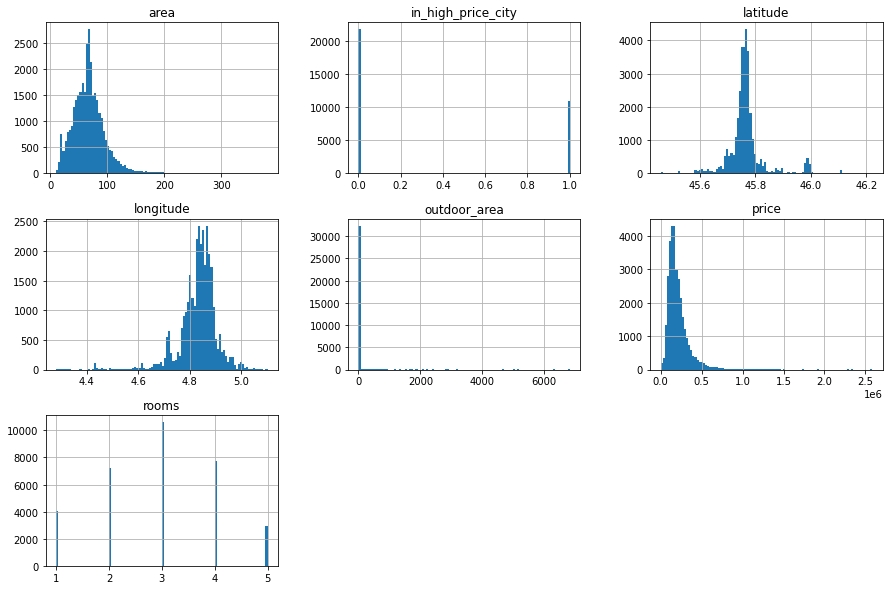

In [51]:
house_data.hist(bins=100,figsize=(15,10))

On peut voir que le "prix" est clairement asymétrique à gauche et doit converger vers une distribution normal.

<AxesSubplot:>

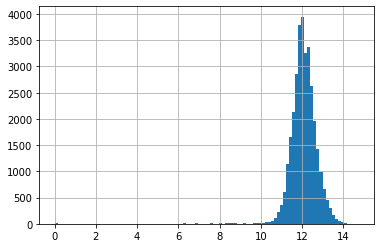

In [65]:
house_data['price_log'] = house_data['price'].apply(np.log)
house_data['price_log'].hist(bins=100)

In [66]:
X = house_data.drop(['price','price_log'],axis=1)
y = house_data['price_log']




# 4. Modélisation

In [68]:
from sklearn.model_selection import train_test_split,KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

kf = KFold(n_splits=5, random_state=50, shuffle=True)

def rmse(y, y_pred):
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return rmse

def cv_rmse(model, X, y, kf):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
    return rmse

## 4.1 Sélection des modèles

In [46]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

ridge = RidgeCV(cv=kf)
svr = SVR()
gbr = GradientBoostingRegressor(random_state=50)
rf = RandomForestRegressor(random_state=50)

models = [ridge, svr, gbr, rf]
model_names = ['ridge','svr','gbr','rf']
scores = {}

In [47]:
for i, model in enumerate(models):
    score = cv_rmse(model,X,y,kf)
    print('{} rmse score: {:.4f}, rmse std: {:.4f}'.format(model_names[i], score.mean(), score.std()))
    scores[model_names[i]] = (score.mean(), score.std())
    
rmse_df = pd.DataFrame(scores, index=['rmse_score','rmse_std'])
rmse_df.sort_values('rmse_score', axis=1, inplace=True)
rmse_df

ridge rmse score: 0.5554, rmse std: 0.0572
svr rmse score: 0.5734, rmse std: 0.0533
gbr rmse score: 0.5268, rmse std: 0.0596
rf rmse score: 0.5421, rmse std: 0.0637


,gbr,rf,ridge,svr
rmse_score,0.526790,0.542061,0.555395,0.573434
rmse_std,0.059598,0.063724,0.057212,0.053338


## 4.2 Sélection des paramètres 

In [69]:
from sklearn.model_selection import GridSearchCV

param_dict = {
    'n_estimators':[100,500,1000],
    'learning_rate':[0.1,0.05,0.01],
    'max_depth': [3,5,7]
}

grid = GridSearchCV(gbr,param_dict,cv=3,scoring='neg_mean_squared_error',n_jobs=-1)
grid.fit(X_train,y_train)

print("RMSE in training set: ", np.sqrt(-grid.best_score_))
print("RMSE in test set: ", np.sqrt(-grid.score(X_test,y_test)))
print("Best parameter set: ", grid.best_params_)

RMSE in training set:  0.5161856008856414
RMSE in test set:  0.5615245239196881
Best parameter set:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}


En comparant les scores, on peut considérer que la capacité de généralisation du modèle est acceptable.

## 4.3 Prediction

In [71]:
gbr = GradientBoostingRegressor(n_estimators=1000,
                                learning_rate=0.01,
                                max_depth=3,
                                random_state=50)

gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
rmse_score = rmse(np.exp(y_test),np.exp(y_pred))
print("RMSE:",rmse_score)

RMSE: 77060.77273585658


Si aucune opération logarithmique n'est effectuée sur 'price' au départ, les paramètres du modèle obtenus sont les suivants:
{n_estimators=500,learning_rate=0.01,max_depth=7}, le RMSE obtenu est environ 69000.

Évidemment, cette valeur n'est pas très agréable.



# 5. Remarque sur l'algorithme




Dans ce cas, on utilise l'algorithme intégré, qui 
- convient mieux aux données présentant de grandes différences entre les types de caractéristiques 
- nécessite un prétraitement relativement faible des données

Plus précisément, le modèle utilisé appartient au modèle **Boosting**, qui peut ajuster les poids de la fonction de prédiction en fonction de l'ajustement constant, et par rapport au modèle de **Bagging**, il aura un biais de prédiction plus faible.
    

Cependant, comme il s'agit d'un calcul en série, la construction du modèle peut prendre du temps. En particulier dans le monde réel, la dimension des données peut être très élevée et la distribution est clairsemée, auquel cas l'avantage de l'utilisation des modèles de boosting sera réduit.

# 6. Perspectives d'améliorations

## 6.1 Données

Sur un plan logique, dans une transaction de vente de maison, le prix est fortement corrélé aux caractéristiques de la maison elle-même (par exemple, étage, date de construction, entretien de la maison, disposition de la maison, etc.)

Dans ce projet, en revanche, il n'y a qu'une description très simple des trois dimensions. En fait, après plusieurs expériences, l'effet sur l'amélioration des résultats de la prédiction n'est pas très important, indépendamment de la normalisation des données, du remplacement du modèle ou de l'ajustement des paramètres du modèle.

On peut s'attendre à ce que la prédiction du modèle soit bien améliorée avec plus d'informations sur les caractéristiques des maisons.

## 6.2 Négligence du facteur temps

Le facteur temps était auparavant ignoré pour faciliter le traitement. Cette démarche n'est pas très rigoureuse. 

Il est évidemment possible que les prix des logements évoluent dans le temps, mais le degré d'évolution dépend également de la région. Lorsque le nombre de caractéristiques autres que le temps est relativement faible, nous pouvons également utiliser la prévision de séries chronologiques.

## 6.3 Sélection des features

Au cours de ce processus, j'ai logiquement divisé les données géographiques directement en classes de latitude et de longitude et en classes de description.

Et pour ces descriptions d'adresses en langage naturel, j'ai choisi une variable qui délimite plus soigneusement les régions géographiques et je l'ai utilisée pour créer une nouvelle variable "booléenne".

Les situations réelles exigent une compréhension plus précise de la signification de chaque variable et une discussion en équipe pour déterminer celles qui doivent être utilisées.

Et la variable créée pour la zone de prix des logements peut être une variable numérique, ce qui permet d'obtenir des informations plus détaillées.